In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries,concatenate
from darts.models import RNNModel
from darts.metrics import mse, rmse, r2_score, mase, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.model_selection import TimeSeriesSplit


# Configurações de visualização
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# 1. Carregar e preparar os dados
target_columns = [
    'Temperature','Precipitation_log','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df1 = pd.read_csv("_old/data/cleaned_data.csv")

In [9]:
encoders = {
    "cyclic":{
        "future":["month","dayofyear","day","hour","minute"],
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [10]:
# 4. Definir e treinar o modelo
best_r2 = float('-inf')
best_fold = -1
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df1)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
            "accelerator": "auto",
            "callbacks": [early_stopper],
        }
    train_df_fold, val_df_fold = df1.iloc[train_idx], df1.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='30min')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='30min')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = RNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=48,
        hidden_dim=128,
        n_rnn_layers=2,
        n_epochs=100,
        batch_size=32,
        dropout=0.2,
        add_encoders=encoders,
        training_length=60,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-6},  # Definir taxa de aprendizado
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        verbose=True
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=12,
        stride=1,
        retrain=False,
        last_points_only=True,
        verbose=True
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_fold = fold + 1
    
print(f"O melhor fold foi {best_fold}") 
    

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 155 K  | train
6 | V               | Linear           | 1.0 K  | train
-------------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.628     Total estimated model params size (MB)
7    


Fold 1

Treinando o modelo...
Train set: 875 samples
Validation set: 874 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 155 K  | train
6 | V               | Linear           | 1.0 K  | train
-------------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.628     Total estimated model params size (MB)
7    

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                            MSE        RMSE         MAE        R2       SMAPE
Temperature           94.445367    9.718301    9.008686 -2.780602   97.127984
Precipitation_log      0.001599    0.039991    0.014009 -0.165506  198.492763
Humidity             249.993887   15.811195   12.033897  0.261910   18.537308
Wind_Speed_kmh         1.949033    1.396078    1.190585 -1.455447  136.403632
Soil_Moisture      19309.631916  138.959102  115.239719  0.288633    1.355754
Soil_Temperature      65.578526    8.098057    7.179953 -1.360244   68.043314
Wind_Dir_Sin           0.352231    0.593490    0.467110 -0.017148  118.650979
Wind_Dir_Cos           0.623238    0.789454    0.559044 -0.061627   87.913464
O R2 desse fold foi -0.6612539623482382

Fold 2

Treinando o modelo...
Train set: 1749 samples
Validation set: 874 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.115


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.087


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.036


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
  return 1 - ss_errors / ss_tot
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
  return 1 - ss_errors / ss_tot
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                             MSE        RMSE         MAE        R2       SMAPE
Temperature           121.530907   11.024106    8.223412 -1.795768   40.665379
Precipitation_log       0.001298    0.036025    0.028530      -inf  200.000000
Humidity             1987.163801   44.577615   32.287358 -9.191464   51.600998
Wind_Speed_kmh          3.854590    1.963311    1.734552 -5.127633  147.464470
Soil_Moisture      507396.031661  712.317367  647.339763 -0.186623    8.552024
Soil_Temperature      155.242818   12.459648    8.783907 -1.104345   41.085508
Wind_Dir_Sin            0.799671    0.894243    0.716069 -1.193409  138.068764
Wind_Dir_Cos            0.642007    0.801254    0.628917 -0.090008  108.509945
O R2 desse fold foi -inf

Fold 3

Treinando o modelo...
Train set: 2623 samples
Validation set: 874 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.009. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 155 K  | train
6 | V               | Linear           | 1.0 K  | train
-------------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.628     Total estimated model params size (MB)
7    

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                            MSE        RMSE         MAE        R2       SMAPE
Temperature           46.808753    6.841692    5.889315 -0.293976   27.855265
Precipitation_log      0.000286    0.016916    0.010087 -0.700878  198.222916
Humidity             136.226486   11.671610    7.469147  0.542988   14.541322
Wind_Speed_kmh         0.714143    0.845070    0.661424  0.063406   51.431514
Soil_Moisture      81817.211774  286.037081  249.881467 -0.027346    3.489289
Soil_Temperature      64.338937    8.021156    6.634231 -0.269350   30.134425
Wind_Dir_Sin           0.306514    0.553637    0.406511  0.138064   93.190954
Wind_Dir_Cos           0.407080    0.638028    0.477401  0.300508   92.212330
O R2 desse fold foi -0.03082308276433024

Fold 4

Treinando o modelo...
Train set: 3497 samples
Validation set: 874 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 155 K  | train
6 | V               | Linear           | 1.0 K  | train
-------------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.628     Total estimated model params size (MB)
7    

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                             MSE        RMSE         MAE        R2       SMAPE
Temperature            15.303508    3.911970    2.927262  0.422928   22.865583
Precipitation_log       0.003830    0.061884    0.023696 -0.172386  197.718048
Humidity              186.426965   13.653826    9.750740  0.451573   14.279923
Wind_Speed_kmh          0.892724    0.944840    0.717948 -0.211298   67.419031
Soil_Moisture      228408.213411  477.920719  438.288074  0.375060    5.831382
Soil_Temperature       20.874407    4.568852    3.063455  0.298572   19.002517
Wind_Dir_Sin            0.379118    0.615725    0.459589 -0.050472  100.726529
Wind_Dir_Cos            0.554605    0.744718    0.519566  0.023952   84.330962
O R2 desse fold foi 0.142241130097751

Fold 5

Treinando o modelo...
Train set: 4371 samples
Validation set: 874 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.007. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                            MSE        RMSE         MAE         R2       SMAPE
Temperature            9.576827    3.094645    2.147237   0.696736   13.256858
Precipitation_log      0.000473    0.021751    0.009716 -11.837989  199.825963
Humidity             132.228182   11.499051    7.951737   0.453080   14.191199
Wind_Speed_kmh         0.739026    0.859666    0.698387   0.228824   60.246767
Soil_Moisture      17893.458983  133.766434  109.896612   0.842881    1.400892
Soil_Temperature      13.375915    3.657310    2.267947   0.593539   12.574042
Wind_Dir_Sin           0.312415    0.558941    0.440990   0.132312   95.603488
Wind_Dir_Cos           0.388480    0.623282    0.473005   0.359853   90.860645
O R2 desse fold foi -1.0663453029700851
O melhor fold foi 5


In [ ]:
if isinstance(forecasts, list):
    print(f"Historical_forecasts retornou uma lista de {len(forecasts)} séries temporais.")
    forecasts = concatenate(forecasts)
print(f"Formato das previsões: {len(forecasts)}")
print(f"Início da previsão: {forecasts_t.start_time()}")
print(f"Fim da previsão: {forecasts_t.end_time()}")
print(f"Início da validação: {train_fold.start_time()}")
print(f"Fim da validação: {train_fold.end_time()}")

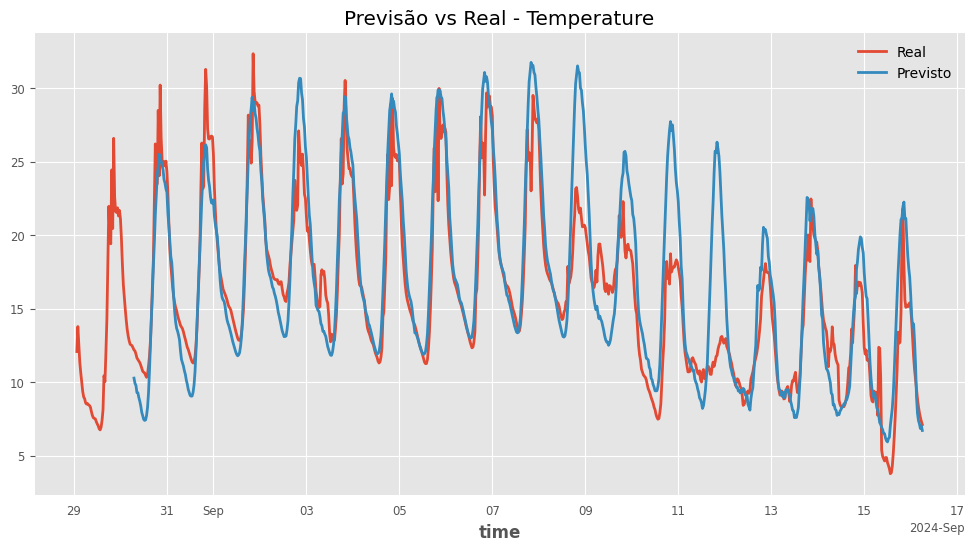

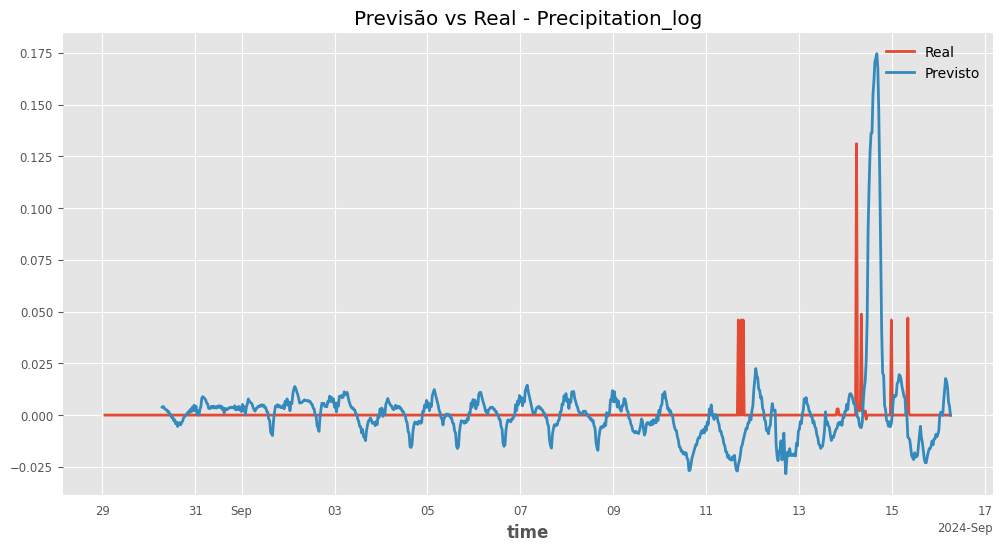

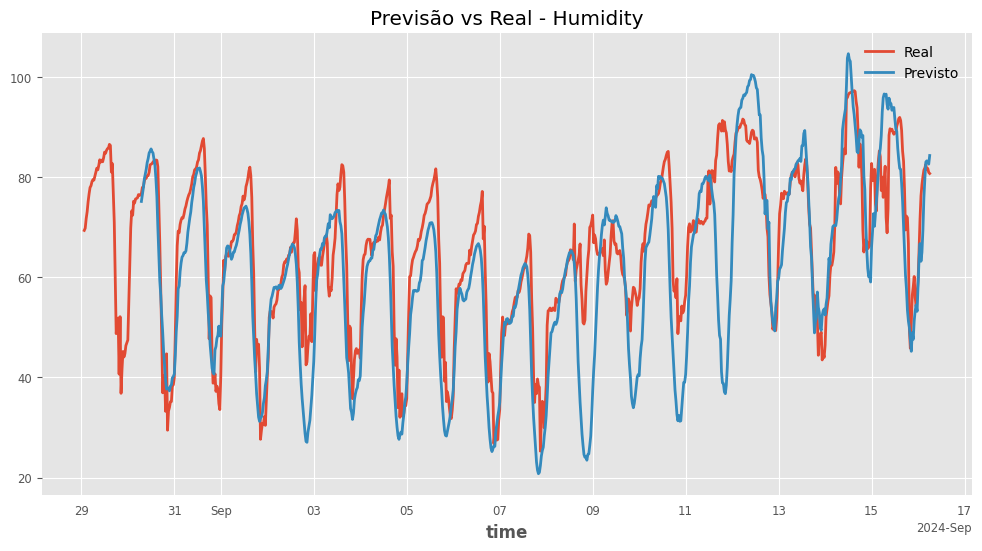

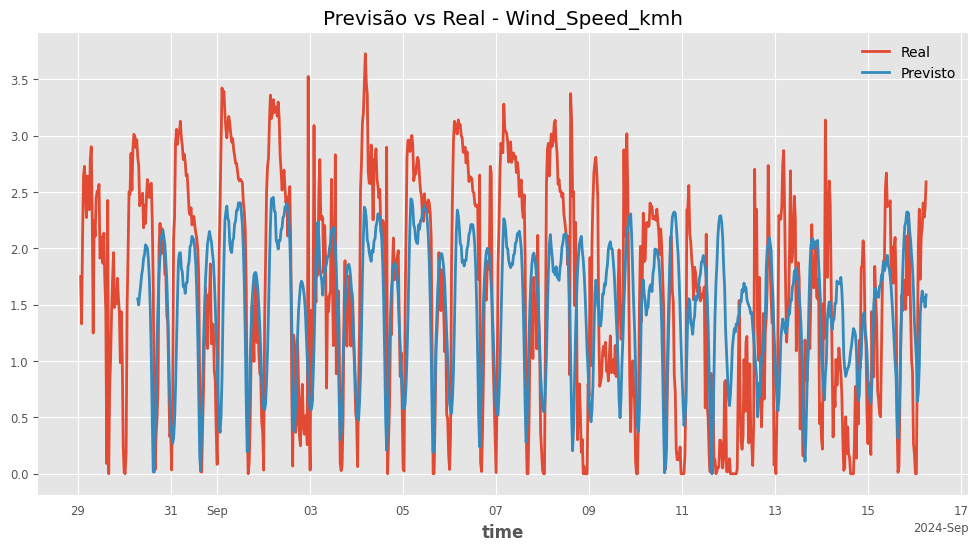

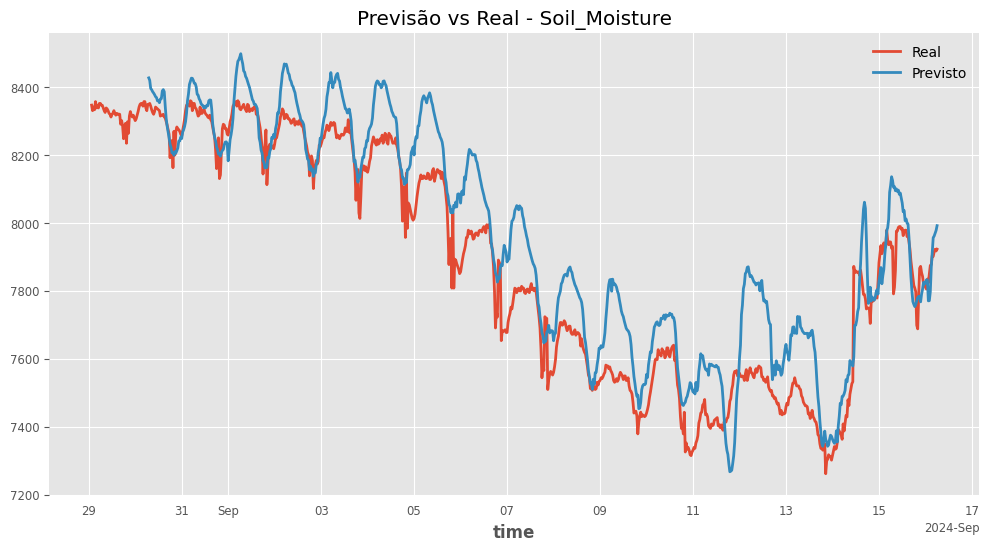

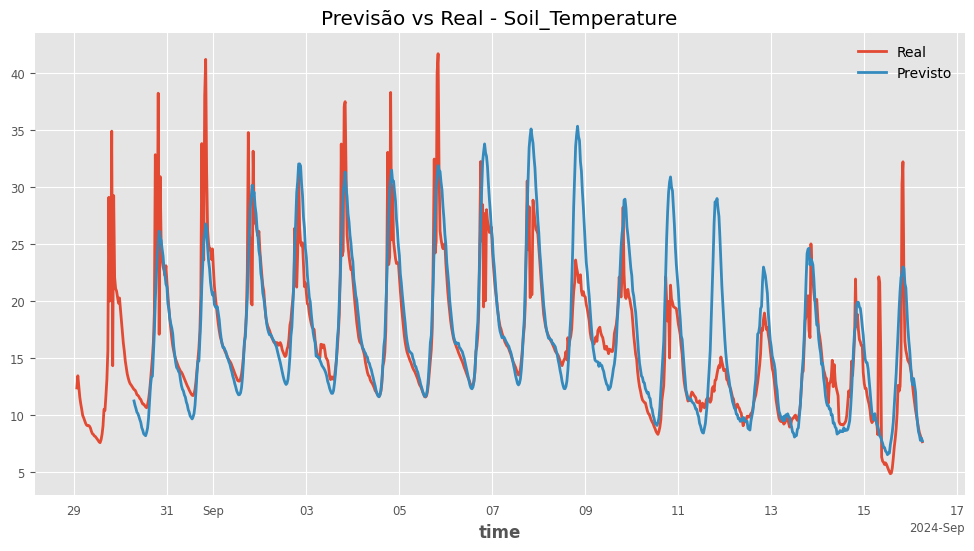

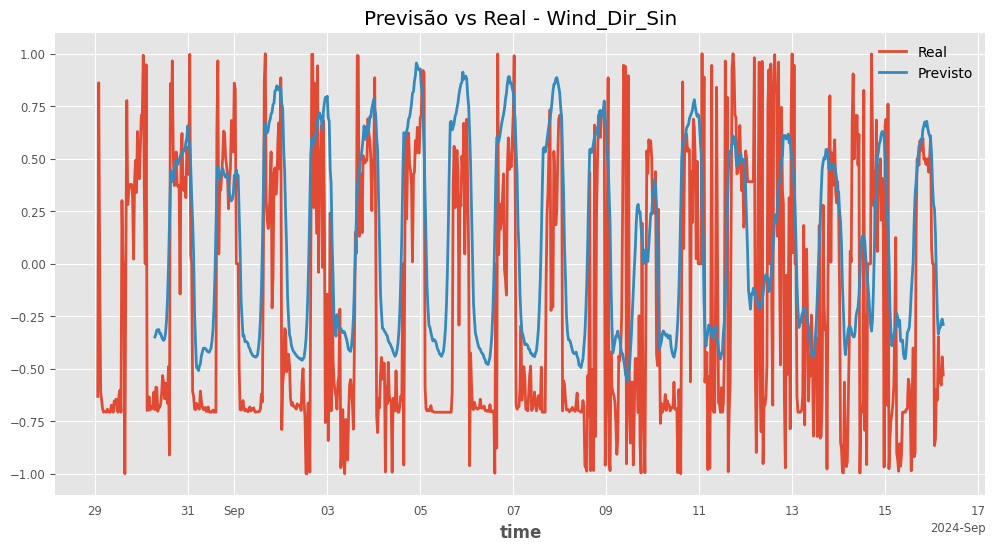

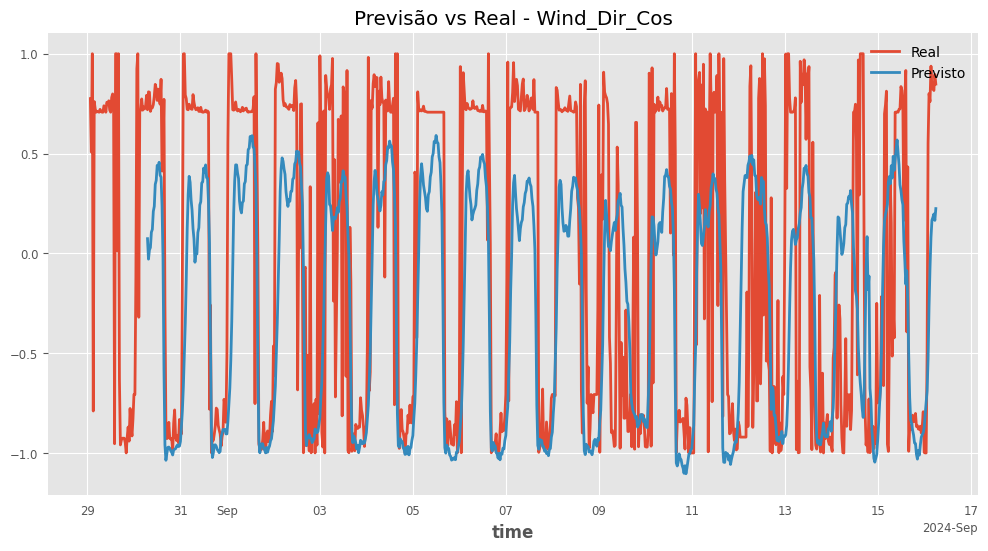

In [11]:
for target in target_columns:
    plt.figure()  # Cria uma nova figura para cada target
    s[target].plot(label='Real')
    forecasts_t[target].plot(label='Previsto')
    plt.title(f'Previsão vs Real - {target}')
    plt.legend()
    plt.grid(True)
    plt.show()